In [1]:
#imports
import scipy as sp
import math
import numpy as np

import pprint  as pp
import matplotlib.pyplot as plt
from functools import partial
from ipywidgets import interact




### Set up constants 

In [2]:
#given params:
#E
c_Ena       = 45
c_Ek        =-80
c_El        =-59
#g
c_gna_bar    = 120
c_gk_bar     = 36
c_gl        = 0.3
#C (cap membrana)
c_C         = 1

### define functions for ease of handling and extensibility

In [3]:
#diffs
f_dVdt = lambda t , V , n , Ix, Cm , g , E : (Ix - g(V,n) * ( V - E(V,n) ) ) / Cm
f_dndt = lambda t , V , n , alpha_n , beta_n :  alpha_n(V) * (1-n) - beta_n(V) * n

#alpha|beta -> m -> g_i -> g -> E
f_alpha_m = lambda V : ( V + 45 )   /   ( 10 * (1 - np.exp (-(V+45)/10) ) )
f_alpha_n = lambda V : ( V + 60 )   /   ( 100 * (1 - np.exp (-(V+60)/10) )  )
f_beta_m  = lambda V : 4    *np.exp (   -(V+70) / 18 )   
f_beta_n  = lambda V : 0.125*np.exp (   -(V+70) / 80 )     

f_m     = lambda V , alpha_m , beta_m : alpha_m(V) / (alpha_m(V) + beta_m(V) )


f_gna   = lambda V , n , gna_bar , m : gna_bar * m(V)**3 * (1-n)
f_gk    = lambda V , n , gk_bar : gk_bar *n**4
f_gl    = lambda V , n : c_gl
f_g     = lambda V , n , gna , gk , gl: gna(V,n) + gk(V,n) + gl(V,n)
f_E     = lambda V , n, Ena, Ek, El, gna, gk , gl : np.average([Ena, Ek, El],weights=[gna(V,n),gk(V,n),gl(V,n)])


## Note que esta vez el problema de valor inicial tiene 3 variables:
- tiempo
- voltaje
- n (canales ab de apertura de sodio) 
##### en el lab anterior solo había una ec diff. en este hay un sistema de 2 ecs. diff:
$$\left\{ \frac{dV}{dt} , \frac{dn}{dt} ; t,v,n \right\}
$$



### Partially evaluate functions with given constants:

In [4]:

fp_m    =  partial ( f_m , alpha_m = f_alpha_m , beta_m = f_beta_m )

fp_gna  = partial ( f_gna , gna_bar = c_gna_bar, m = fp_m )
fp_gk   = partial ( f_gk , gk_bar = c_gk_bar )
#fp_gl x as f_gl requieres no substitutions as of this model

fp_g    = partial (f_g , gna = fp_gna , gk = fp_gk , gl = f_gl) 

fp_E    = partial (f_E, Ena = c_Ena , Ek = c_Ek, El= c_El, gna = fp_gna, gk = fp_gk , gl = f_gl )

#dvdt signature:: t , V , n , Ix, Cm , g , E
fp_dVdt = partial(  f_dVdt ,     
#                        Ix  = p_Ix    ,
                        Cm  = c_C     , 
                        g   = fp_g    ,
                        E   = fp_E  )

#dndt signature:: t , V , n , alpha_n , beta_n 
fp_dndt = partial(  f_dndt , 
                        alpha_n=f_alpha_n , 
                        beta_n=f_beta_n )



## Sacar el dibujito:
- primero con interact
- abajo sin interact (por si acaso)

In [ ]:
#p_Ix =  25 #mA ?
#iv_v = 0
#iv_n = 0.1

# y0 = V, y1 = n
@interact(Ix = (0,50.0,0.05), iv_v = (-10,10,0.01) , iv_n = (0,1,0.001) , span_M = (0,10,0.1) )
def plotFunc( Ix, iv_v , iv_n , span_M):
    span_t = (0,span_M)
    fpp_dVdt = partial(fp_dVdt , Ix = Ix )
    simpleNeuron = lambda t , y :  (fpp_dVdt( t ,y[0] ,y[1]) , fp_dndt( t , y[0] ,y[1]))
    sol = sp.integrate.solve_ivp(simpleNeuron , span_t , [iv_v, iv_n] , method='LSODA' )
    plt.plot(sol.t,sol.y[0])
 

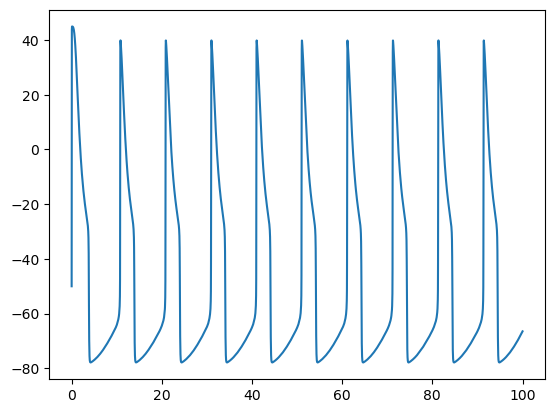

In [80]:
p_Ix =  25 #mA ?
iv_v = -50
iv_n = 0.0
span_M = 100 # s
# y0 = V, y1 = n
#@interact(Ix = (0,50.0,0.05), iv_v = (-10,10,0.01) , iv_n = (0,1,0.001) , span_M = (0,10,0.1) )
span_t = ( 0 , span_M )
fpp_dVdt = partial(fp_dVdt , Ix =p_Ix )
simpleNeuron = lambda t , y :  (fpp_dVdt( t ,y[0] ,y[1]) , fp_dndt( t , y[0] ,y[1]))


sol = sp.integrate.solve_ivp(simpleNeuron , span_t , [iv_v, iv_n] , method='LSODA', dense_output=True )
plt.plot(sol.t,sol.y[0])


[None, None, None, None, None]


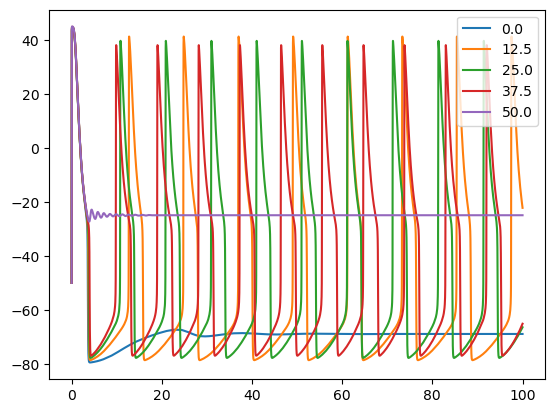

In [93]:

#map eval
p_Ixr = np.linspace(0,50,5)
sols = map( partial(sp.integrate.solve_ivp, t_span=span_t, y0 = [iv_v,iv_n], method='LSODA' ) ,
        map( lambda f : (lambda t,y :(f ( t , y[0],y[1] ) , fp_dndt( t,y[0],y[1] )  )  ) , 
                map( lambda x : partial(fp_dVdt , Ix= x ) , 
                    p_Ixr ) 
        )
    )
def plotF (s):
    plt.plot( s.t , s.y[0] ) #"Ix = {val}".format(val = s[0]) )
    plt.legend(p_Ixr)

z = [*map(plotF,sols)]